In [1]:
from lucent.optvis.transform import pad, jitter, random_rotate, random_scale
from lucent.optvis import render, param, transform, objectives
from math import sqrt, floor
import torchvision

import torch

from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class LongcatNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(3, 9, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2_bn = nn.BatchNorm2d(9)
        self.conv2 = nn.Conv2d(9, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3_bn = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 25, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4_bn = nn.BatchNorm2d(25)
        self.conv4 = nn.Conv2d(25, 36, 3)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.conv5_bn = nn.BatchNorm2d(36)
        self.conv5 = nn.Conv2d(36, 36, 3)
  
        self.conv6_bn = nn.BatchNorm2d(36)
        self.conv6 = nn.Conv2d(36, 49, 3)

        self.conv7_bn = nn.BatchNorm2d(49)
        self.conv7 = nn.Conv2d(49, 49, 3)
        
        self.conv8_bn = nn.BatchNorm2d(49)
        self.conv8 = nn.Conv2d(49, 49, 3)
        
        self.conv9_bn = nn.BatchNorm2d(49)
        self.conv9 = nn.Conv2d(49, 49, 3)
        self.pool9 = nn.MaxPool2d(2, 2)

        self.conv10_bn = nn.BatchNorm2d(49)
        self.conv10 = nn.Conv2d(49, 49, 3)
        self.pool10 = nn.MaxPool2d(2, 2)

        self.fc = nn.Linear(1764, 4)

    def forward(self, x):
        x = self.bn1(x)
        x = self.conv2_bn(self.pool1(F.relu(self.conv1(x))))
        x = self.conv3_bn(self.pool2(F.relu(self.conv2(x))))
        x = self.conv4_bn(self.pool3(F.relu(self.conv3(x))))
        x = self.conv5_bn(self.pool4(F.relu(self.conv4(x))))

        x = self.conv6_bn(F.relu(self.conv5(x)))  
        x = self.conv7_bn(F.relu(self.conv6(x)))
        x = self.conv8_bn(F.relu(self.conv7(x)))
        x = self.conv9_bn(F.relu(self.conv8(x)))
        
        
        x = self.conv10_bn(self.pool9(F.relu(self.conv9(x))))
        x = self.pool10(F.relu(self.conv10(x)))
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = self.fc(x)
        return x

In [3]:
longcat = LongcatNet()
longcat = longcat.to(device)

longcat.load_state_dict(torch.load('saved_models/longcat/epoch_7_batch_5000.pth', map_location=device))
longcat.to(device).eval()

LongcatNet(
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_bn): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 25, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_bn): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(25, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5_bn): BatchNorm2d(36, eps=

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [6]:
def lucent_show_layer(model, layer, n_channels,
                      param_f=None, transforms=None,
                      optimizer=None, preprocess=True, image_size=128):
    n_row = int( floor( sqrt( n_channels ) ) )
    n_col = int( floor( sqrt( n_channels ) ) )
    _, axs = plt.subplots(n_row, n_col, figsize=(19.55, 20))
    axs = axs.flatten()
    for ix, ax in zip(range(n_row*n_col), axs):
        img = render.render_vis(longcat, f"conv6:{ix}", param_f=param_f,
                                transforms=transforms, preprocess=preprocess, progress=False, show_image=False)[0]
        img = np.reshape(img, (image_size, image_size, 3))
        ax.imshow(img)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.margins(x=0, y=0, tight=True)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

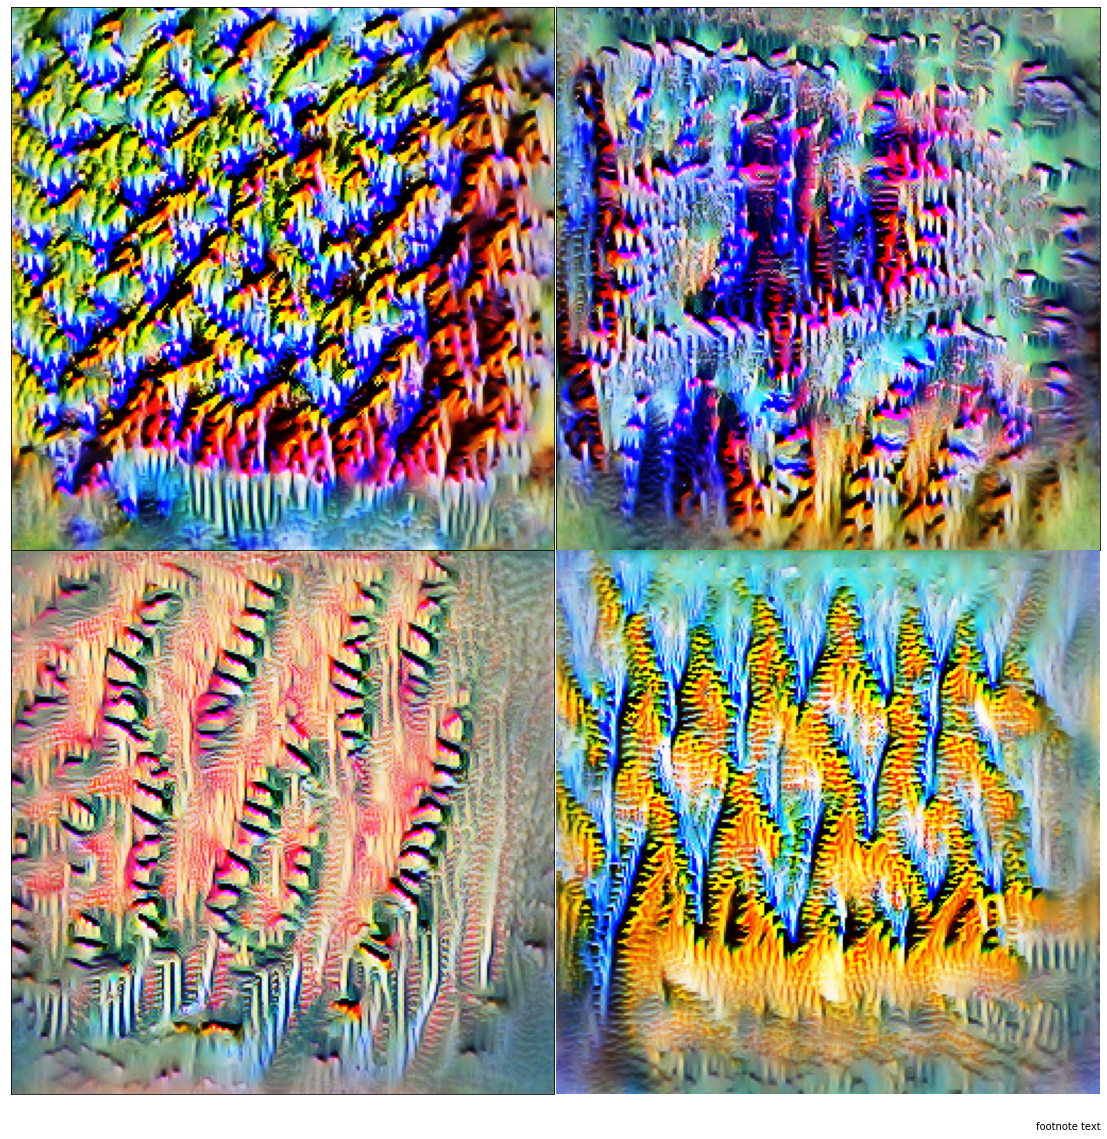

In [27]:
n_row = 2
n_col = 2
fig, axs = plt.subplots(n_row, n_col, figsize=(19.55, 20))
axs = axs.flatten()
for ix, ax in zip(range(n_row*n_col), axs):
    if ix > 3:
        continue
    img = render.render_vis(longcat, f"conv6:{ix}", param_f=lambda: param.image(256),
                            preprocess=True, progress=False, show_image=False)[0]
    img = np.reshape(img, (256, 256, 3))
    ax.imshow(img)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(x=0, y=0, tight=True)

plt.figtext(0.9, 0.1, 'footnote text', horizontalalignment='right')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.savefig('frames/four_channels/test.png', bbox_inches="tight", pad_inches=0)
plt.show()

In [22]:
!rm -rf frames/four_channels/test.png

In [14]:
!mkdir frames

In [15]:
!mkdir frames/four_channels

In [23]:
!ls frames/four_channels

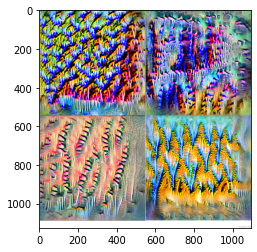

In [29]:
img = mpimg.imread('frames/four_channels/test.png')
plt.imshow(img)
